#### Problem Statement :

Customers send back a substantial part of the products that they purchase online. Return shipping is expensive for online platforms and return orders are said to reach 50% for certain industries and products. Nevertheless, free or inexpensive return shipping has become a customer expectation and de-facto standard in the fierce online competition on clothing, but shops have indirect ways to influence customer purchase behavior. For purchases where return seems likely, a shop could, for example, restrict payment options or display additional marketing communication.

#### Objective:
To predict whether an item would be returned or not.

In [79]:
# loading libraries
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# loading dataset

df = pd.read_csv('TrainingData_V1 (1).csv')
print(df.shape)
df.head()

(79945, 14)


,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,22-06-2016,27-06-2016,643,38,navy,30,49.9,30822,Mrs,17-04-1969,1013,23-06-2016,0
1,10,22-06-2016,27-06-2016,195,xxl,grey,46,19.9,30823,Mrs,22-04-1970,1001,15-03-2015,1
2,11,22-06-2016,05-07-2016,25,xxl,grey,5,79.9,30823,Mrs,22-04-1970,1001,15-03-2015,0
3,32,23-06-2016,26-06-2016,173,m,brown,20,19.9,17234,Mrs,09-01-1960,1013,17-02-2015,0
4,43,23-06-2016,26-06-2016,394,40,black,44,90.0,30827,Mrs,NaN,1006,09-02-2016,1


In [3]:
# checking target
df['return'].value_counts()

0    43283
1    36662
Name: return, dtype: int64

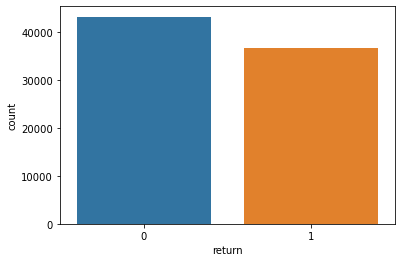

In [4]:
# plotting target composition
sns.countplot(df['return']);

Target is almost balanced with 54% data with value=0 and 46% data with value=1.

In [5]:
# checking 10 random samples
df.sample(10)

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
36696,67208,13-08-2016,14-08-2016,1468,xxl,blue,3,59.9,35944,Mrs,11-12-1972,1003,17-02-2015,0
70485,4342,26-06-2016,NaN,219,39,brown,38,49.9,13839,Mrs,11-11-1947,1011,17-02-2015,0
17948,79995,24-08-2016,28-08-2016,533,xxl,ocher,74,29.9,22505,Mrs,09-11-1952,1015,17-02-2015,1
47680,76316,21-08-2016,23-08-2016,1631,unsized,orange,20,39.9,19176,Mrs,08-02-1970,1002,14-05-2016,0
46405,63773,10-08-2016,14-08-2016,1622,38,blue,34,59.9,40476,Mrs,10-05-1976,1010,07-08-2016,0
65407,52918,05-08-2016,08-08-2016,1497,40,green,1,129.9,18011,Mrs,NaN,1007,10-05-2016,1
64406,43062,26-07-2016,27-07-2016,1557,l,black,31,89.9,7443,Mrs,07-08-1972,1002,12-04-2016,1
52100,20014,30-06-2016,23-07-2016,17,36,blue,11,34.9,31084,Mrs,24-07-1969,1008,25-06-2016,0
20648,6864,27-06-2016,NaN,166,46,olive,6,34.9,15701,Mrs,18-01-1957,1001,17-02-2015,0
56010,59014,07-08-2016,10-08-2016,1903,40,blue,113,69.9,40926,Mrs,28-05-1962,1011,05-09-2015,1


In [6]:
# checking data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79945 entries, 0 to 79944
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_item_id  79945 non-null  int64  
 1   order_date     79945 non-null  object 
 2   delivery_date  72509 non-null  object 
 3   item_id        79945 non-null  int64  
 4   item_size      79945 non-null  object 
 5   item_color     79945 non-null  object 
 6   brand_id       79945 non-null  int64  
 7   item_price     79945 non-null  float64
 8   user_id        79945 non-null  int64  
 9   user_title     79945 non-null  object 
 10  user_dob       72956 non-null  object 
 11  user_state     79945 non-null  int64  
 12  user_reg_date  79945 non-null  object 
 13  return         79945 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 8.5+ MB


We have missing values in data.

order_date, delivery_date, user_dob, user_reg_date are supposed to be datetime features which have to be converted.

certain features are of 'object' type that have to be converted.

In [7]:
# converting to datetime
for item in ['order_date', 'delivery_date', 'user_dob', 'user_reg_date']:
    df[item] = df[item].astype('datetime64')

In [8]:
# converting 'object' to 'category'
for col in df.columns:
    if df[col].dtypes=='object':
        df[col] = df[col].astype('category')

In [9]:
# checking for duplicate entries
df.duplicated().sum()

0

In [10]:
# checking for missing values
df.isnull().sum()

order_item_id       0
order_date          0
delivery_date    7436
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         6989
user_state          0
user_reg_date       0
return              0
dtype: int64

We have missing values in 'delivery_date' and 'user_dob' which are not missing at random. Hence, we cannot impute them with any value we like. So, dropping those missing samples.

In [11]:
# dropping and checking missing values
df.dropna(inplace=True)
df.isnull().sum()

order_item_id    0
order_date       0
delivery_date    0
item_id          0
item_size        0
item_color       0
brand_id         0
item_price       0
user_id          0
user_title       0
user_dob         0
user_state       0
user_reg_date    0
return           0
dtype: int64

In [12]:
# separating 'datetime', 'numerical' and 'categorical' features
# creating datetime features
datetime_feats = [col for col in df.columns if df[col].dtype=='datetime64[ns]']

In [13]:
datetime_feats

['order_date', 'delivery_date', 'user_dob', 'user_reg_date']

In [14]:
# creating categorical features
categorical_feats = [col for col in df.columns if df[col].dtype=='category']

In [15]:
categorical_feats

['item_size', 'item_color', 'user_title']

In [16]:
# creating numerical features
numerical_feats = [col for col in df.columns if col not in datetime_feats and col not in categorical_feats]

In [17]:
numerical_feats

['order_item_id',
 'item_id',
 'brand_id',
 'item_price',
 'user_id',
 'user_state',
 'return']

In [18]:
# checking cardinality of numerical features
for item in numerical_feats:
    print(f"{item}: ", df[item].nunique())

order_item_id:  66162
item_id:  1850
brand_id:  134
item_price:  238
user_id:  15627
user_state:  16
return:  2


Due to low cardinality, we can convert 'user_state' into a categorical feature. Also, since 'return' is our target feature, it should be converted to categorical type.

In [19]:
# converting 'user_state', 'return' to 'category' type
for item in ['user_state', 'return']:
    df[item] = df[item].astype('category')

In [20]:
# removing the converted features from numerical feature list and adding to categorical feature list
for item in ['user_state', 'return']:
    numerical_feats.remove(item)
    categorical_feats.append(item)

In [21]:
numerical_feats

['order_item_id', 'item_id', 'brand_id', 'item_price', 'user_id']

In [22]:
# exploring numerical features
num_df = df[numerical_feats]
num_df.describe()

,order_item_id,item_id,brand_id,item_price,user_id
count,66162.000000,66162.000000,66162.000000,66162.000000,66162.000000
mean,51230.005985,950.998322,30.502101,65.426510,26846.203485
std,28611.894361,701.178110,28.479793,47.956227,14168.124977
min,1.000000,1.000000,1.000000,0.000000,9.000000
25%,26950.250000,223.000000,5.000000,29.900000,14430.000000
50%,51733.500000,927.000000,25.000000,49.900000,30854.500000
75%,75941.750000,1599.000000,44.000000,79.900000,38881.000000
max,100000.000000,2241.000000,138.000000,999.000000,48241.000000


Mean price of items ordered were around 65 with maximum upto 999.

In [23]:
# exploring categorical features
cat_df = df[categorical_feats]
cat_df.describe()

,item_size,item_color,user_title,user_state,return
count,66162,66162,66162,66162,66162
unique,100,77,5,16,2
top,l,black,Mrs,1010,1
freq,8214,12416,63486,15127,33488


In [24]:
# exploring datetime features
date_df = df[datetime_feats]
date_df.describe()

,order_date,delivery_date,user_dob,user_reg_date
count,66162,66162,66162,66162
unique,82,122,8810,572
top,2016-06-27 00:00:00,2016-03-07 00:00:00,1900-11-21 00:00:00,2015-02-17 00:00:00
freq,3413,3808,663,23958
first,2016-01-07 00:00:00,1994-12-31 00:00:00,1900-04-12 00:00:00,2015-01-03 00:00:00
last,2016-12-08 00:00:00,2017-01-24 00:00:00,2011-10-02 00:00:00,2016-12-09 00:00:00


### Numerical features

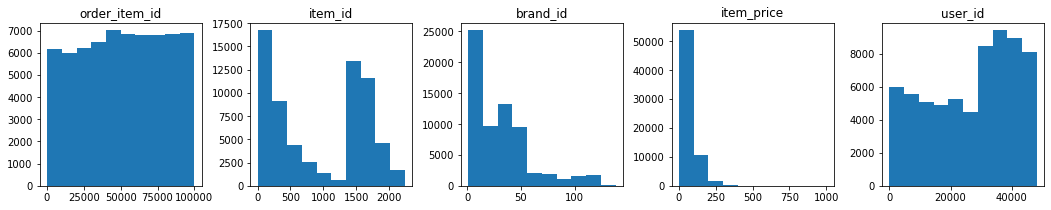

In [25]:
# plotting numerical features
num_df.hist(layout=(1,5), figsize=(18,3), grid=False);

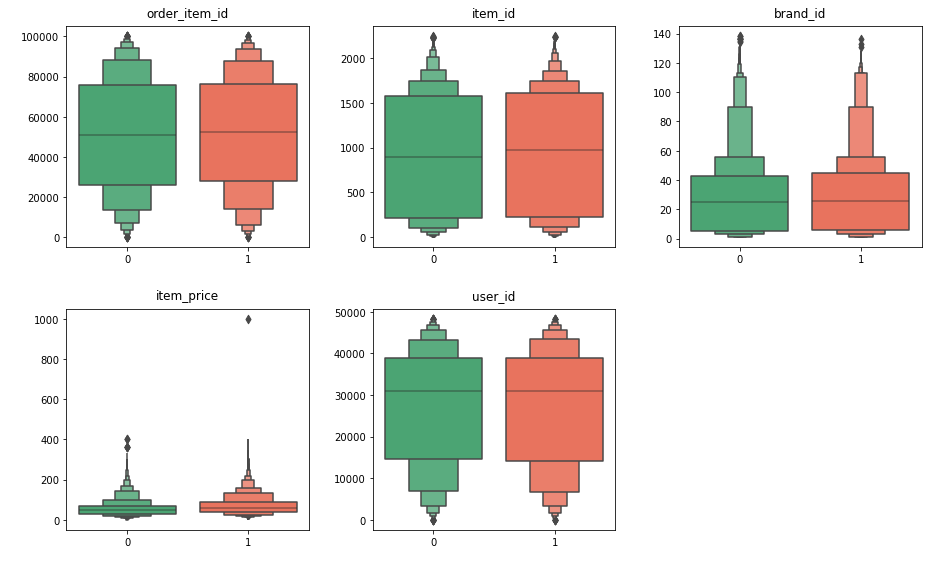

In [26]:
# distribution of numerical features across target
plt.figure(figsize=(13,8))
plotnumber=1

for col in num_df:
    if plotnumber <= num_df.shape[1]:
        ax = plt.subplot(2,3,plotnumber)
        sns.boxenplot(y=num_df[col], x=cat_df['return'], palette=['mediumseagreen', 'tomato'])
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.title(col, pad=10)
        plt.xticks()
    plotnumber +=1
plt.tight_layout()

'brand_id' and 'item_price' looks right skewed. lets check the skewness and see if log transform can create a better skewed feature.

In [27]:
# checking skewness
num_df[['brand_id', 'item_price']].skew()

brand_id      1.244636
item_price    1.790672
dtype: float64

In [28]:
# checking if log transform works
num_df_1 = num_df.copy()  # creating a copy of num_df
for feat in ['brand_id', 'item_price']:
    num_df_1[feat] = np.log1p(num_df_1[feat])

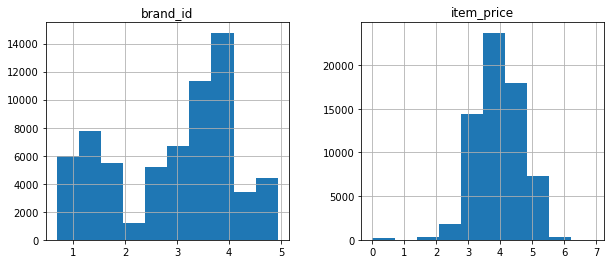

In [29]:
num_df_1[['brand_id', 'item_price']].hist(figsize=(10,4));

In [30]:
# applying log transform
for feat in ['brand_id', 'item_price']:
    num_df[feat] = np.log1p(num_df[feat])

### Categorical features

In [31]:
# converting all features in cat_df to 'category'
for col in cat_df.columns:
    cat_df[col] = cat_df[col].astype('category')

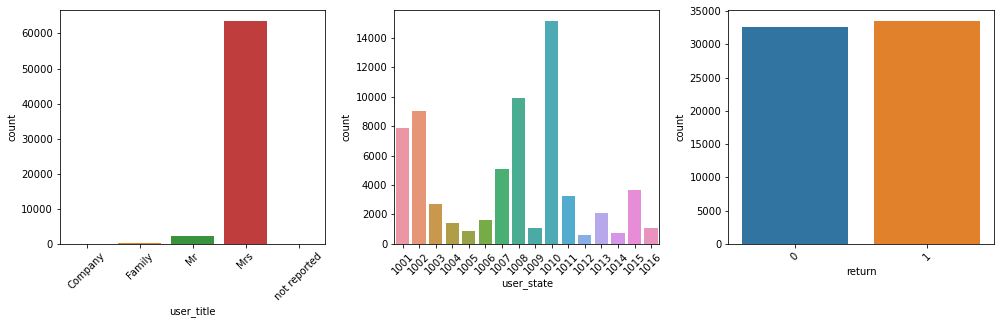

In [32]:
# plotting categorical features

plt.figure(figsize=(14,8))
plotnumber=1

for col in cat_df.drop(['item_size', 'item_color'], axis=1):
    if plotnumber <= cat_df.shape[1]:
        ax = plt.subplot(2,3,plotnumber)
        sns.countplot(cat_df[col])
        plt.xticks(rotation=45)
    plotnumber +=1
plt.tight_layout()

'user_title' is highly imbalanced. Checking if there is any relation with 'return'. If not found, we'll drop the feature.

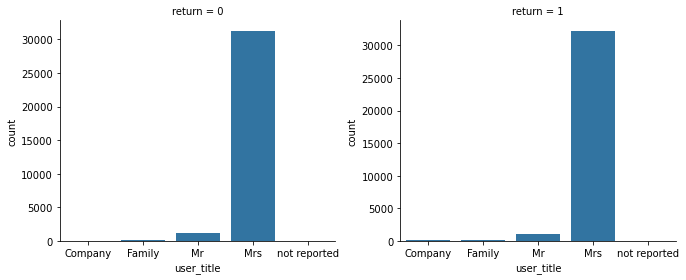

In [33]:
# checking relationship between user_title and return
g = sns.FacetGrid(data=cat_df, col='return', height=4, aspect=1.2, sharey=False)
g.map(sns.countplot, 'user_title')
plt.show()

In [34]:
# dropping 'user_title'
cat_df.drop('user_title', axis=1, inplace=True)

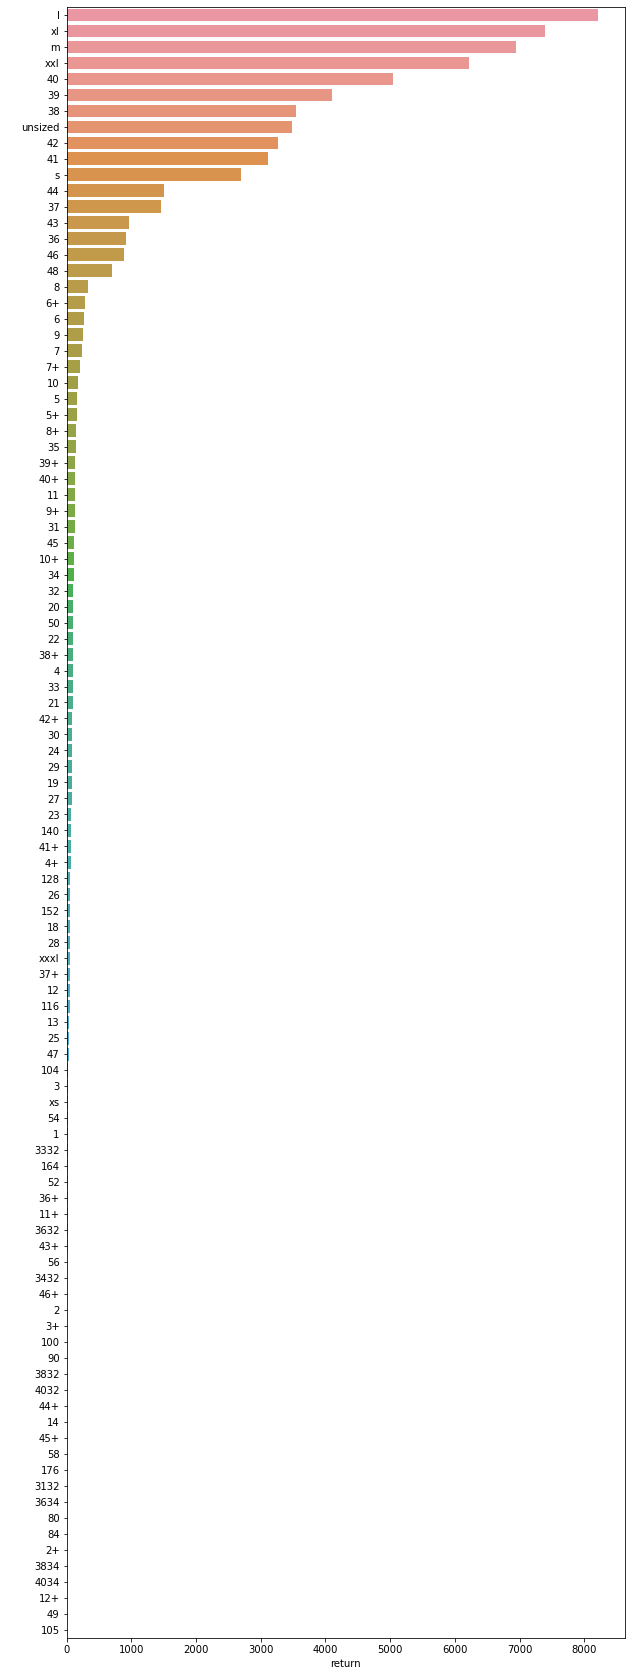

In [35]:
# plotting item_size
plt.figure(figsize=(10,30))
sns.countplot(y=cat_df['item_size'], order=cat_df['item_size'].value_counts().index)
plt.ylabel(' ')
plt.xlabel(col)
plt.show()

In [36]:
# mapping 'item_size'class values
cat_df['item_size'] = np.where(cat_df['item_size']=='s', '39', 
                               np.where(cat_df['item_size']=='m', '40',
                                       np.where(cat_df['item_size']=='l', '42',
                                               np.where(cat_df['item_size']=='xl', '45',
                                                        np.where(cat_df['item_size']=='xxl', '48',
                                                                 np.where(cat_df['item_size']=='xxxl', '50',cat_df['item_size']
                                                       ))))))

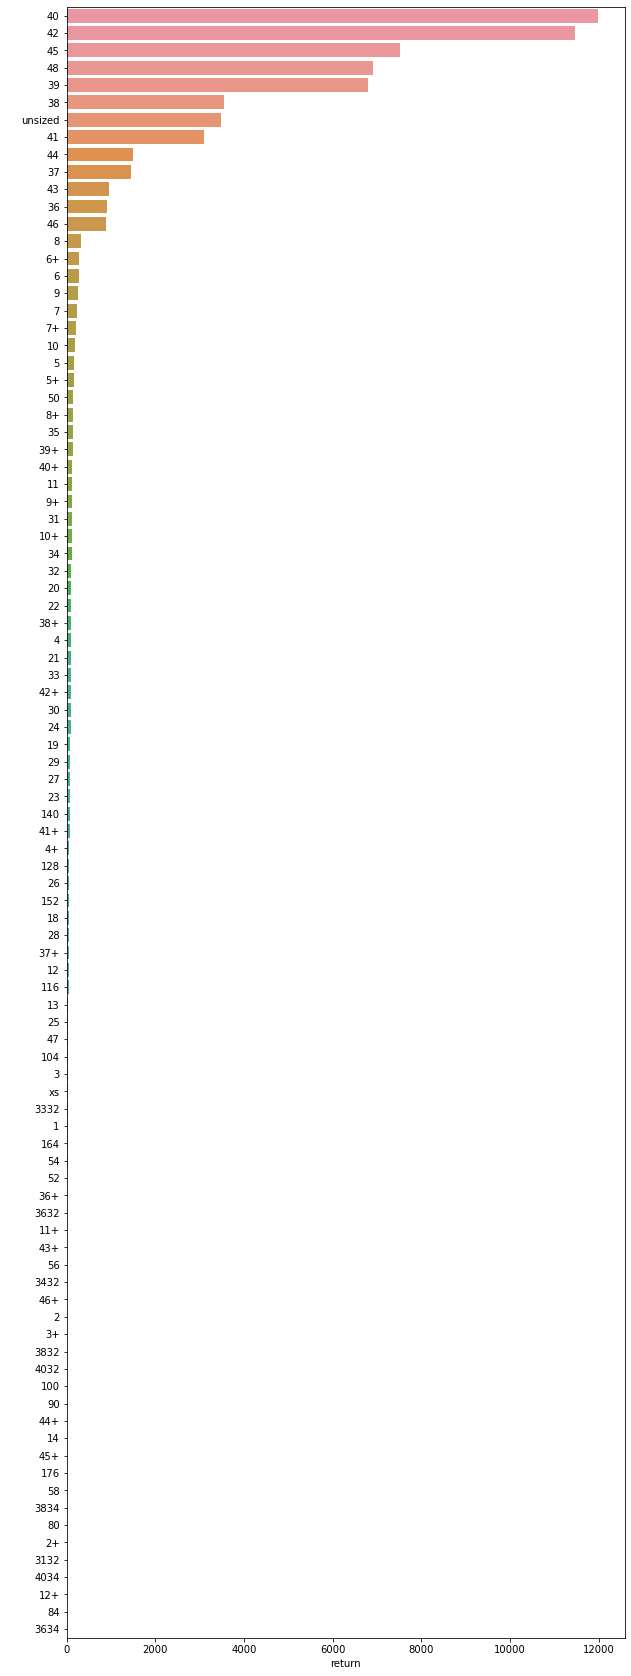

In [37]:
# plotting composition of 'item_size'
plt.figure(figsize=(10,30))
sns.countplot(y=cat_df['item_size'], order=cat_df['item_size'].value_counts().index)
plt.ylabel(' ')
plt.xlabel(col)
plt.show()

In [38]:
# re-arranging classes in 'item_size'
cat_df['item_size'] = np.where(cat_df['item_size'].isin(['21','22','23','24','25','26','27','28','29','30',
                                                     '31','32','33','34','35','36','37','38','39','40',
                                                     '41','42','43','44','45','46','47','48','49','50', 'unsized']), 
                             cat_df['item_size'], 'unsized')

In [39]:
cat_df['item_size'] = np.where(cat_df['item_size'].isin(['21','22','23','24','25','26','27','28','29','30',
                                                     '31','32','33']), 'kids', cat_df['item_size'])

In [40]:
cat_df['item_size'] = np.where(cat_df['item_size'].isin(['34','35','36']), 'small',
                             np.where(cat_df['item_size'].isin(['37','38','39']), 'medium',
                                      np.where(cat_df['item_size'].isin(['40','41','42']), 'large',
                                               np.where(cat_df['item_size'].isin(['43','44','45','46','47', '48','49','50']), 'extra large',
                                                        cat_df['item_size']))))

In [41]:
cat_df['item_size'] = np.where(cat_df['item_size']=='kids', 'small', cat_df['item_size'])

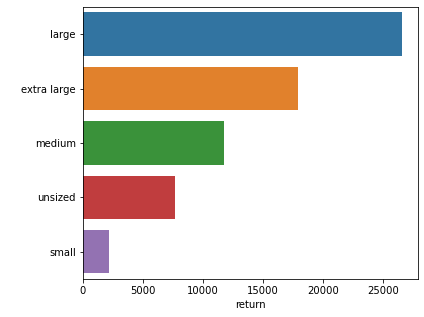

In [42]:
# plotting 'item_size'
plt.figure(figsize=(6,5))
sns.countplot(y=cat_df['item_size'], order=cat_df['item_size'].value_counts().index)
plt.ylabel(' ')
plt.xlabel(col)
plt.show()

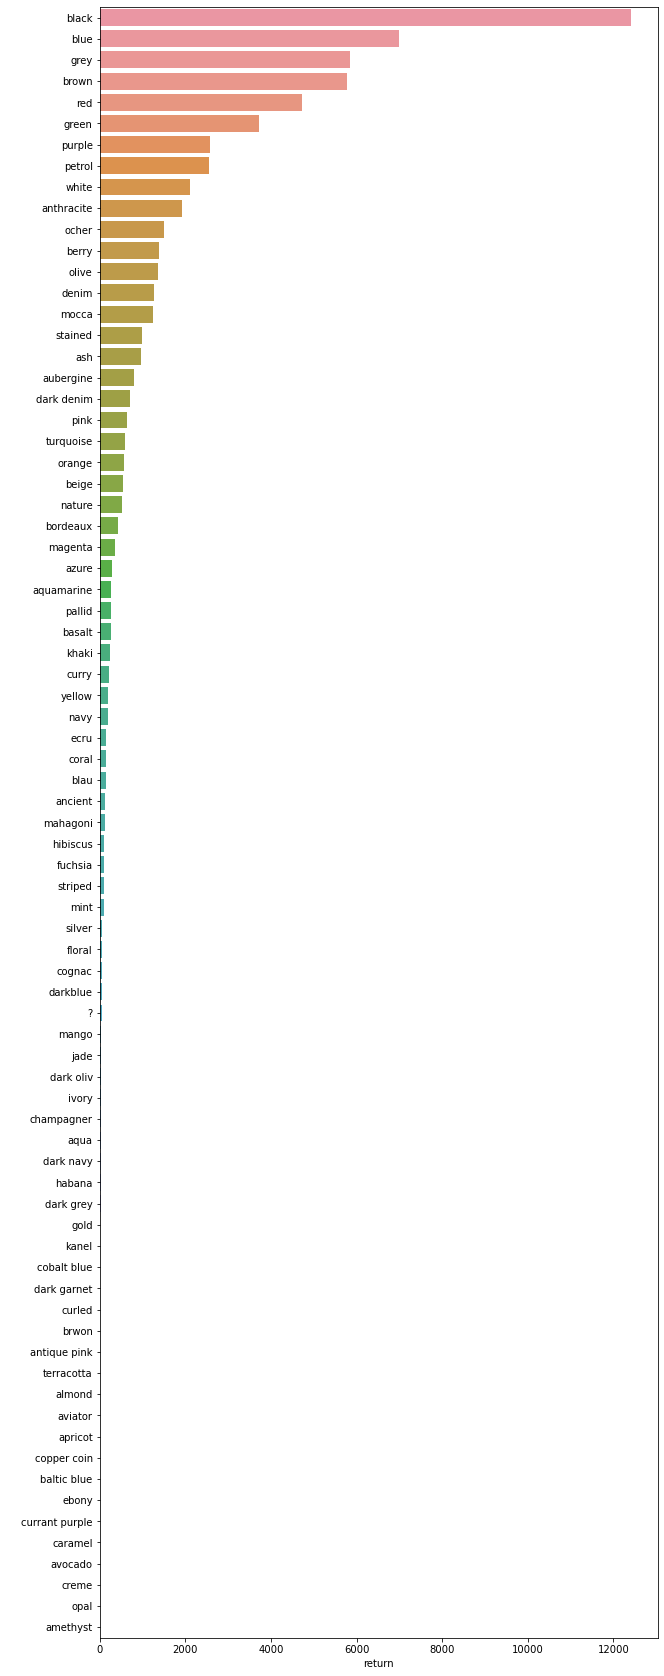

In [43]:
# plotting 'item_color'
plt.figure(figsize=(10,30))
sns.countplot(y=cat_df['item_color'], order=cat_df['item_color'].value_counts().index)
plt.ylabel(' ')
plt.xlabel(col)
plt.show()

In [44]:
# rearranging classes in 'item_color'
cat_df['item_color'] = np.where(cat_df['item_color'].isin(['yellow','orange','red','violet','blue','green']), 'primary', cat_df['item_color'])

In [45]:
cat_df['item_color'] = np.where(cat_df['item_color'].isin(['black','grey','white']), 'black & white', cat_df['item_color'])

In [46]:
cat_df['item_color'] = np.where(cat_df['item_color'].isin(['black & white', 'primary']), cat_df['item_color'], 'others')

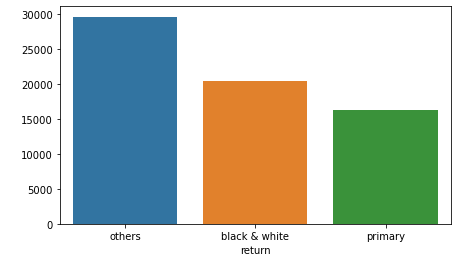

In [47]:
# plotting 'item_color'
plt.figure(figsize=(7,4))
sns.countplot(x=cat_df['item_color'])
plt.ylabel(' ')
plt.xlabel(col)
plt.show()

In [48]:
# defining a function for frequency encoding
def frequency_encoding(df,feats):
    for feat in feats:
        indx = (df.groupby(feat).size()/cat_df.shape[0]).index
        vals = (df.groupby(feat).size()/cat_df.shape[0]).values
        maps = dict()
        for i,v in list(zip(indx,vals)):
            maps[i]=v
        df[feat] = df[feat].map(maps) 

In [49]:
# frequency encoding 'user_state', 'item_color'
frequency_encoding(cat_df, ['user_state', 'item_color'])

In [50]:
cat_df.head()

,item_size,item_color,user_state,return
0,medium,0.447024,0.032027,0
1,extra large,0.308168,0.118739,1
2,extra large,0.308168,0.118739,0
3,large,0.447024,0.032027,0
5,large,0.447024,0.150177,1


In [51]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66162 entries, 0 to 79944
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   item_size   66162 non-null  object  
 1   item_color  66162 non-null  float64 
 2   user_state  66162 non-null  category
 3   return      66162 non-null  category
dtypes: category(2), float64(1), object(1)
memory usage: 3.7+ MB


In [52]:
# converting 'user_state' to float and 'return' to int
cat_df['user_state'] = cat_df['user_state'].astype('float')
cat_df['return'] = cat_df['return'].astype('int')

In [53]:
# concatenating num_df and cat_df
new_df = pd.concat([num_df, cat_df], axis=1)
new_df.head()

,order_item_id,item_id,brand_id,item_price,user_id,item_size,item_color,user_state,return
0,1,643,3.433987,3.929863,30822,medium,0.447024,0.032027,0
1,10,195,3.850148,3.039749,30823,extra large,0.308168,0.118739,1
2,11,25,1.791759,4.393214,30823,extra large,0.308168,0.118739,0
3,32,173,3.044522,3.039749,17234,large,0.447024,0.032027,0
5,45,448,4.290459,4.109233,30828,large,0.447024,0.150177,1


### Datetime features

In [54]:
# converting datetime features to datetime
for feat in ['order_date', 'delivery_date', 'user_dob', 'user_reg_date']:
    date_df[feat] = pd.to_datetime(date_df[feat])

Creating 2 new features 'delivery_time' and 'user_age' using datetime features.

In [55]:
date_df['delivery_time'] = np.abs(date_df['delivery_date'] - date_df['order_date'])
date_df['user_age'] = np.abs(date_df['user_reg_date'] - date_df['user_dob'])

In [56]:
# dropping 'order_date', 'delivery_date', 'user_dob', 'user_reg_date'
date_df.drop(['order_date', 'delivery_date', 'user_dob', 'user_reg_date'], axis=1, inplace=True)
date_df.head()

,delivery_time,user_age
0,5 days,17234 days
1,5 days,16398 days
2,46 days,16398 days
3,3 days,19892 days
5,3 days,18150 days


In [57]:
# cleaning up 'delivery_time' and 'user_age'
for col in date_df.columns:
    date_df[col] = date_df[col].apply(lambda x: str(x).strip(" days"))
    date_df[col] = date_df[col].apply(lambda x: x.strip(" days 00:00:00"))

In [58]:
date_df['user_age'] = date_df['user_age'].astype('str').astype('int')

In [59]:
date_df['delivery_time'] = np.where(date_df['delivery_time']=='', 0, date_df['delivery_time'])

In [60]:
date_df['delivery_time'] = date_df['delivery_time'].astype('int')

In [61]:
date_df.head()

,delivery_time,user_age
0,5,17234
1,5,16398
2,46,16398
3,3,19892
5,3,1815


In [62]:
# converting 'user_age' in days to age in years
date_df['user_age'] = date_df['user_age']/365

In [63]:
date_df.head()

,delivery_time,user_age
0,5,47.216438
1,5,44.926027
2,46,44.926027
3,3,54.498630
5,3,4.972603


In [64]:
# concatenating date_df with new_df
data = pd.concat([new_df, date_df], axis=1)
print(data.shape)
data.head()

(66162, 11)


,order_item_id,item_id,brand_id,item_price,user_id,item_size,item_color,user_state,return,delivery_time,user_age
0,1,643,3.433987,3.929863,30822,medium,0.447024,0.032027,0,5,47.216438
1,10,195,3.850148,3.039749,30823,extra large,0.308168,0.118739,1,5,44.926027
2,11,25,1.791759,4.393214,30823,extra large,0.308168,0.118739,0,46,44.926027
3,32,173,3.044522,3.039749,17234,large,0.447024,0.032027,0,3,54.498630
5,45,448,4.290459,4.109233,30828,large,0.447024,0.150177,1,3,4.972603


In [65]:
# checking for any new missing values
data.isnull().sum()

order_item_id    0
item_id          0
brand_id         0
item_price       0
user_id          0
item_size        0
item_color       0
user_state       0
return           0
delivery_time    0
user_age         0
dtype: int64

Since 'item_size' was imbalanced, we will upsamle the data based on 'item_size' to make it a little more balanced.

In [66]:
# checking class distribution in 'item_size'
y = data['item_size']
X = data.drop('item_size', axis=1)

counter = Counter(y)

for k,v in counter.items():
    per = 100*v/len(y)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= medium, n=11787 (17.82%)
Class= extra large, n=17945 (27.12%)
Class= large, n=26570 (40.16%)
Class= unsized, n=7642 (11.55%)
Class= small, n=2218 (3.35%)


In [67]:
# oversampling 'item_size' and checking new class distribution of 'item_size'
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)

for k,v in counter.items():
    per = 100*v/len(y)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= medium, n=26570 (20.00%)
Class= extra large, n=26570 (20.00%)
Class= large, n=26570 (20.00%)
Class= unsized, n=26570 (20.00%)
Class= small, n=26570 (20.00%)


In [68]:
# concatenating upsampled features to get the desired dataframe
df = pd.concat([X, y], axis=1)
print("Upsampled data shape: ", df.shape)

Upsampled data shape:  (132850, 11)


In [69]:
# ordinal encoding 'item_size'
df['item_size'] = np.where(df['item_size']=='unsized', 0, 
                           np.where(df['item_size']=='small', 1,
                                    np.where(df['item_size']=='medium', 2,
                                             np.where(df['item_size']=='large', 3, 4))))
df.head()

,order_item_id,item_id,brand_id,item_price,user_id,item_color,user_state,return,delivery_time,user_age,item_size
0,1,643,3.433987,3.929863,30822,0.447024,0.032027,0,5,47.216438,2
1,10,195,3.850148,3.039749,30823,0.308168,0.118739,1,5,44.926027,4
2,11,25,1.791759,4.393214,30823,0.308168,0.118739,0,46,44.926027,4
3,32,173,3.044522,3.039749,17234,0.447024,0.032027,0,3,54.498630,3
4,45,448,4.290459,4.109233,30828,0.447024,0.150177,1,3,4.972603,3


In [70]:
# converting all values into float
for col in df.drop('return', axis=1).columns:
    df[col] =  df[col].astype('float')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132850 entries, 0 to 132849
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  132850 non-null  float64
 1   item_id        132850 non-null  float64
 2   brand_id       132850 non-null  float64
 3   item_price     132850 non-null  float64
 4   user_id        132850 non-null  float64
 5   item_color     132850 non-null  float64
 6   user_state     132850 non-null  float64
 7   return         132850 non-null  int32  
 8   delivery_time  132850 non-null  float64
 9   user_age       132850 non-null  float64
 10  item_size      132850 non-null  float64
dtypes: float64(10), int32(1)
memory usage: 10.6 MB


In [72]:
# checking the composition of 'return'
df['return'].value_counts()

0    82087
1    50763
Name: return, dtype: int64

In [73]:
# checking class distribution of 'return'
y = df['return']
X = df.drop('return', axis=1)

counter = Counter(y)

for k,v in counter.items():
    per = 100*v/len(y)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= 0, n=82087 (61.79%)
Class= 1, n=50763 (38.21%)


In [74]:
# oversampling 'return' and checking new class distribution of 'return'
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)

for k,v in counter.items():
    per = 100*v/len(y)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= 0, n=82087 (50.00%)
Class= 1, n=82087 (50.00%)


In [75]:
# concatenating upsampled features to get the desired dataframe
df = pd.concat([X, y], axis=1)
print("Upsampled data shape: ", df.shape)

Upsampled data shape:  (164174, 11)


In [76]:
# splitting the data into features and label
y = df['return']
X = df.drop('return', axis=1)
print(X.shape, y.shape)

(164174, 10) (164174,)


In [77]:
# creating train and test data with 30% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(114921, 10) (49253, 10) (114921,) (49253,)


In [80]:
# scaling up the features for ease of calculation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
# selecting a good baseline model using cross validation

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LOG', LogisticRegression()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [82]:
# calculating scores for all the models
names = []
results = []
for name, model in models:
    fold = StratifiedKFold(n_splits=5)
    score = cross_val_score(model, X_train_scaled, y_train, cv=fold, scoring='accuracy')
    names.append(name)
    results.append(score)

In [83]:
# printing model scores for selecting best model
score_dict = dict(zip(names, results))
print('Model Scores\n')
for k,v in score_dict.items():
    print(f"{k}: {round(v.mean(),5)}")

Model Scores

KNN: 0.68189
LOG: 0.60174
DTC: 0.71881
RFC: 0.78133


In [84]:
# selecting Random forest as the best model
model = RandomForestClassifier()

In [85]:
# fitting model
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [86]:
# calculating scores based on 5 fold stratified crossvalidation
fold = StratifiedKFold(n_splits=5)
train_score = cross_val_score(model, X_train_scaled, y_train, cv=fold, scoring='accuracy')
test_score = cross_val_score(model, X_test_scaled, y_test, cv=fold, scoring='accuracy')
print('Train data score: ', np.mean(train_score))
print('Test data score: ', np.mean(test_score))

Train data score:  0.7806841126808213
Test data score:  0.7334171005855263


In [87]:
# making a prediction for viewing classification metrics
y_pred = model.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)  # calculating auc score

In [88]:
# printing auc score and classification report
print(f"AUC: {auc}\n")
print(classification_report(y_test, y_pred))

AUC: 0.7896915043342643

              precision    recall  f1-score   support

           0       0.79      0.78      0.79     24603
           1       0.79      0.80      0.79     24650

    accuracy                           0.79     49253
   macro avg       0.79      0.79      0.79     49253
weighted avg       0.79      0.79      0.79     49253



# Test data 

In [89]:
# Run this command if the excel file is not loading
# !pip install openpyxl

In [90]:
# uploading the test data for submission
test_data = pd.read_excel('TestingData_For_Candidate (1).xlsx')
print(test_data.shape)
test_data.head()

(20055, 13)


,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
0,26,2016-06-23,2016-06-26,92,xl,turquoise,42,69.90,9392,Mrs,1962-04-14,1010,2016-03-24
1,28,2016-06-23,2016-07-02,2,xxl,green,2,19.90,9392,Mrs,1962-04-14,1010,2016-03-24
2,37,2016-06-23,2016-06-26,895,38,white,39,39.95,30826,Mrs,1964-04-27,1001,2015-02-17
3,56,2016-06-23,NaT,5,l,white,5,69.90,30828,Mrs,1966-05-13,1008,2016-01-21
4,65,2016-06-23,NaT,55,40,purple,1,89.90,22948,Mrs,1957-03-11,1001,2015-02-17


In [91]:
# creating a copy of test data
test = test_data.copy()

In [92]:
# checking duplicates
test.duplicated().sum()

0

In [93]:
# missing values
test.isnull().sum()

order_item_id       0
order_date          0
delivery_date    1882
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         1736
user_state          0
user_reg_date       0
dtype: int64

In [94]:
# dropping all missing observations
test = test.dropna()

In [95]:
test.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
0,26,2016-06-23,2016-06-26,92,xl,turquoise,42,69.90,9392,Mrs,1962-04-14,1010,2016-03-24
1,28,2016-06-23,2016-07-02,2,xxl,green,2,19.90,9392,Mrs,1962-04-14,1010,2016-03-24
2,37,2016-06-23,2016-06-26,895,38,white,39,39.95,30826,Mrs,1964-04-27,1001,2015-02-17
5,80,2016-06-23,2016-06-26,57,l,purple,3,24.90,16075,Mrs,1969-11-03,1003,2015-11-22
6,95,2016-06-23,2016-06-26,57,xl,olive,3,34.90,17124,Mrs,1949-03-03,1015,2015-08-02


### Processing test data

In [96]:
# creating a function for processing datetime features

def process_date(date_df):
    # converting datetime features to datetime
    for feat in ['order_date', 'delivery_date', 'user_dob', 'user_reg_date']:
        date_df[feat] = pd.to_datetime(date_df[feat])
    date_df['delivery_time'] = np.abs(date_df['delivery_date'] - date_df['order_date'])
    date_df['user_age'] = np.abs(date_df['user_reg_date'] - date_df['user_dob'])
    # dropping 'order_date', 'delivery_date', 'user_dob', 'user_reg_date'
    date_df.drop(['order_date', 'delivery_date', 'user_dob', 'user_reg_date'], axis=1, inplace=True)
    for col in date_df.columns:
        date_df[col] = date_df[col].apply(lambda x: str(x).strip(" days"))
        date_df[col] = date_df[col].apply(lambda x: x.strip(" days 00:00:00"))
    date_df['user_age'] = date_df['user_age'].astype('str').astype('int')
    date_df['delivery_time'] = np.where(date_df['delivery_time']=='', 0, date_df['delivery_time'])
    date_df['delivery_time'] = date_df['delivery_time'].astype('int')
    date_df['user_age'] = date_df['user_age']/365
    return date_df

In [97]:
# creating a dataframe of datetime features in test data
date_test = test[['order_date', 'delivery_date', 'user_dob', 'user_reg_date']]

In [98]:
# processing the datetime features using the above function
date_test = process_date(date_test)
date_test.head()

,delivery_time,user_age
0,3,53.980822
1,9,53.980822
2,3,50.843836
5,3,4.608219
6,3,66.460274


In [99]:
# concatenating processed datetime features and removing existing datetime features from test set
test = pd.concat([test, date_test], axis=1)
test.drop(['order_date', 'delivery_date', 'user_dob', 'user_reg_date'], axis=1, inplace=True)
test.head()

,order_item_id,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age
0,26,92,xl,turquoise,42,69.90,9392,Mrs,1010,3,53.980822
1,28,2,xxl,green,2,19.90,9392,Mrs,1010,9,53.980822
2,37,895,38,white,39,39.95,30826,Mrs,1001,3,50.843836
5,80,57,l,purple,3,24.90,16075,Mrs,1003,3,4.608219
6,95,57,xl,olive,3,34.90,17124,Mrs,1015,3,66.460274


In [100]:
# applying log transform on numerical features
for feat in ['brand_id', 'item_price']:
    test[feat] = np.log1p(test[feat])

In [101]:
# creating a function for processing 'item_size'
def process_itemsize(cat_df):
    # mapping 'item_size'class values
    cat_df['item_size'] = np.where(cat_df['item_size']=='s', '39', 
                                   np.where(cat_df['item_size']=='m', '40',
                                           np.where(cat_df['item_size']=='l', '42',
                                                   np.where(cat_df['item_size']=='xl', '45',
                                                            np.where(cat_df['item_size']=='xxl', '48',
                                                                     np.where(cat_df['item_size']=='xxxl', '50',cat_df['item_size']
                                                           ))))))
    cat_df['item_size'] = np.where(cat_df['item_size'].isin(['21','22','23','24','25','26','27','28','29','30',
                                                     '31','32','33','34','35','36','37','38','39','40',
                                                     '41','42','43','44','45','46','47','48','49','50', 'unsized']), 
                             cat_df['item_size'], 'unsized')
    cat_df['item_size'] = np.where(cat_df['item_size'].isin(['21','22','23','24','25','26','27','28','29','30',
                                                     '31','32','33']), 'kids', cat_df['item_size'])
    cat_df['item_size'] = np.where(cat_df['item_size'].isin(['34','35','36']), 'small',
                             np.where(cat_df['item_size'].isin(['37','38','39']), 'medium',
                                      np.where(cat_df['item_size'].isin(['40','41','42']), 'large',
                                               np.where(cat_df['item_size'].isin(['43','44','45','46','47', '48','49','50']), 'extra large',
                                                        cat_df['item_size']))))
    cat_df['item_size'] = np.where(cat_df['item_size']=='kids', 'small', cat_df['item_size'])
    # ordinal encoding 'item_size'
    cat_df['item_size'] = np.where(cat_df['item_size']=='unsized', 0,
                                   np.where(cat_df['item_size']=='small', 1,
                                            np.where(cat_df['item_size']=='medium', 2,
                                                     np.where(cat_df['item_size']=='large', 3, 4))))
    return cat_df

In [102]:
# processing 'item_size'
test = process_itemsize(test)
test.head()

,order_item_id,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age
0,26,92,4,turquoise,3.761200,4.261270,9392,Mrs,1010,3,53.980822
1,28,2,4,green,1.098612,3.039749,9392,Mrs,1010,9,53.980822
2,37,895,0,white,3.688879,3.712352,30826,Mrs,1001,3,50.843836
5,80,57,3,purple,1.386294,3.254243,16075,Mrs,1003,3,4.608219
6,95,57,4,olive,1.386294,3.580737,17124,Mrs,1015,3,66.460274


In [103]:
# frequency encoding 'user_state', 'item_color' usinf frequency_encoding function
frequency_encoding(test, ['user_state', 'item_color'])

In [104]:
# dropping 'user_title'
test.drop('user_title', axis=1, inplace=True)

In [105]:
test.head()

,order_item_id,item_id,item_size,item_color,brand_id,item_price,user_id,user_state,delivery_time,user_age
0,26,92,4,0.002388,3.761200,4.261270,9392,0.057631,3,53.980822
1,28,2,4,0.013437,1.098612,3.039749,9392,0.057631,9,53.980822
2,37,895,0,0.007603,3.688879,3.712352,30826,0.029413,3,50.843836
5,80,57,3,0.009839,1.386294,3.254243,16075,0.009598,3,4.608219
6,95,57,4,0.005456,1.386294,3.580737,17124,0.013905,3,66.460274


In [106]:
# converting all features to type 'float'
for col in test:
    test[col] = test[col].astype('float')

In [107]:
test.head()

,order_item_id,item_id,item_size,item_color,brand_id,item_price,user_id,user_state,delivery_time,user_age
0,26.0,92.0,4.0,0.002388,3.761200,4.261270,9392.0,0.057631,3.0,53.980822
1,28.0,2.0,4.0,0.013437,1.098612,3.039749,9392.0,0.057631,9.0,53.980822
2,37.0,895.0,0.0,0.007603,3.688879,3.712352,30826.0,0.029413,3.0,50.843836
5,80.0,57.0,3.0,0.009839,1.386294,3.254243,16075.0,0.009598,3.0,4.608219
6,95.0,57.0,4.0,0.005456,1.386294,3.580737,17124.0,0.013905,3.0,66.460274


In [108]:
# scaling up test data
test_scaled = scaler.transform(test)

In [109]:
# making a prediction using the Random forest model and scaled up test data
y_pred = model.predict(test_scaled)

In [110]:
# viewing original test dataframe
test_data.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
0,26,2016-06-23,2016-06-26,92,xl,turquoise,42,69.90,9392,Mrs,1962-04-14,1010,2016-03-24
1,28,2016-06-23,2016-07-02,2,xxl,green,2,19.90,9392,Mrs,1962-04-14,1010,2016-03-24
2,37,2016-06-23,2016-06-26,895,38,white,39,39.95,30826,Mrs,1964-04-27,1001,2015-02-17
3,56,2016-06-23,NaT,5,l,white,5,69.90,30828,Mrs,1966-05-13,1008,2016-01-21
4,65,2016-06-23,NaT,55,40,purple,1,89.90,22948,Mrs,1957-03-11,1001,2015-02-17


In [111]:
# dropping all mising value observations from test dataframe
test_data.dropna(inplace=True)

In [112]:
# concatenating the results to original dataframe
test_data['return'] = y_pred

In [113]:
test_data.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,26,2016-06-23,2016-06-26,92,xl,turquoise,42,69.90,9392,Mrs,1962-04-14,1010,2016-03-24,1
1,28,2016-06-23,2016-07-02,2,xxl,green,2,19.90,9392,Mrs,1962-04-14,1010,2016-03-24,0
2,37,2016-06-23,2016-06-26,895,38,white,39,39.95,30826,Mrs,1964-04-27,1001,2015-02-17,0
5,80,2016-06-23,2016-06-26,57,l,purple,3,24.90,16075,Mrs,1969-11-03,1003,2015-11-22,0
6,95,2016-06-23,2016-06-26,57,xl,olive,3,34.90,17124,Mrs,1949-03-03,1015,2015-08-02,0


In [114]:
# Creating the final submission file
test_data.to_csv('submission.csv')